# **Neutrino Oscillation with DUNE**

## PHYS591000 Physics AI Final Project

This is the project implementing ML to find out the $\Theta_{13}$ and $\delta_{cp}$ using the neutrino data from DUNE experiment.  
Original link: [Kaggle](https://www.kaggle.com/competitions/phys591000-2023-final-project-i)

> Author(s): Siang-Yuan Lin, Yuan-Yen Peng  
> Email(s) : sylin@gapp.nthu.edu.tw, garyphys0915@gapp.nthu.edu.tw  
> Licence : MIT  
> Data : May, 2023


### prerequisites

1. reset all varialbes
2. import curcial modules
3. mount google drive
4. check the GPU is on


In [167]:
%reset -f # clear all variables

Don't know how to reset  #, please run `%reset?` for details
Don't know how to reset  clear, please run `%reset?` for details
Don't know how to reset  all, please run `%reset?` for details
Don't know how to reset  variables, please run `%reset?` for details


In [168]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt

from numba import njit  # acceleration kernel
import concurrent.futures  # parallel execution
import tensorflow as tf

In [169]:
# # mount the google drive to retrieve dataset

# from google.colab import drive

# drive.mount('/content/drive')

In [170]:
# check the tensorflow and GPU

print(f"Using Tensorflow {tf.__version__}")
device_name = tf.test.gpu_device_name()
if device_name != "/device:GPU:0":
    raise SystemError("GPU device not found")
print(
    f"Found GPU adn CPU.\nTensorFlow has access to the following devices:\n{tf.config.list_physical_devices()}"
)


Using Tensorflow 2.9.0
Found GPU adn CPU.
TensorFlow has access to the following devices:
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2023-05-18 23:32:24.239043: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-05-18 23:32:24.239303: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


### import datasets

1. check files exist
2. retrieve data
3. check shapes of data


In [171]:
# import the datasets and check the files

import os

path = "./phys591000-2023-final-project/"  # run on the local machine
# path = "/content/drive/Shareddrives/2023AI_final/2023AI_final/phys591000-2023-final-project/" # run on the google colab
for dirname, _, filenames in os.walk(path):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        print("-> The file is", filename)
if not os.path.isfile(path + "neutrino_test_data.npz") or os.path.isfile(
    path + "neutrino_train_data.npz"
):
    raise FileNotFoundError("test/train data was not found or is a directory")


./phys591000-2023-final-project/neutrino_test_data.npz
-> The file is neutrino_test_data.npz
./phys591000-2023-final-project/neutrino_training_data.npz
-> The file is neutrino_training_data.npz


In [172]:
%%time
# take out data from the datasets

data_train = np.load(path + "neutrino_training_data.npz")  # ideal data
data_test = np.load(path + "neutrino_test_data.npz")  # pseudo-exp data

name_train = data_train.files
name_test = data_test.files

print(f"Train: {name_train}")
print(f"Test : {name_test}")

# Create a ThreadPoolExecutor with the maximum number of worker threads
with concurrent.futures.ThreadPoolExecutor() as executor:
    ve_train, vebar_train, vu_train, vubar_train, theta23_train, delta_train, ldm_train = executor.map(lambda n: data_train[n], name_train)
    ve_test, vebar_test, vu_test, vubar_test = executor.map(lambda n: data_test[n], name_test)


Train: ['ve', 'vebar', 'vu', 'vubar', 'theta23', 'delta', 'ldm']
Test : ['ve', 'vebar', 'vu', 'vubar']
CPU times: user 12.4 s, sys: 1.23 s, total: 13.6 s
Wall time: 4.98 s


In [173]:
# check the data shape

print(
    f"""# TRAIN
ve_train     :{ve_train.shape}
vebar_train  :{vebar_train.shape}
vu_train     :{vu_train.shape}
vubar_train  :{vubar_train.shape}
theta23_train:{theta23_train.shape}
delta_train  :{delta_train.shape}
ldm_train    :{ldm_train.shape}
"""
)
print(
    f"""# TEST
ve_test      :{ve_test.shape}
vebar_test   :{vebar_test.shape}
vu_test      :{vu_test.shape}
vubar_test   :{vubar_test.shape}
"""
)


# TRAIN
ve_train     :(1000000, 65)
vebar_train  :(1000000, 65)
vu_train     :(1000000, 65)
vubar_train  :(1000000, 65)
theta23_train:(1000000,)
delta_train  :(1000000,)
ldm_train    :(1000000,)

# TEST
ve_test      :(1000, 65)
vebar_test   :(1000, 65)
vu_test      :(1000, 65)
vubar_test   :(1000, 65)



### preprocessing

1. create train and test data
2. inspect data structure
3. check data
4. normalize data
5. <pending>


In [174]:
# create train and test data
X_train = np.stack((ve_train, vebar_train, vu_train, vubar_train), axis=-1)
Y_train = np.stack((theta23_train, delta_train, ldm_train), axis=-1)
X_test = np.stack((ve_test, vebar_test, vu_test, vubar_test), axis=-1)

print(
    f"""
The shape of x_train: {X_train.shape}
The shape of y_train: {Y_train.shape}
The shape of x_test : {X_test.shape}
"""
)



The shape of x_train: (1000000, 65, 4)
The shape of y_train: (1000000, 3)
The shape of x_test : (1000, 65, 4)



In [175]:
# define plotting functions


def four_plot(data_format: list) -> None:
    train, test = data_format
    bins = np.arange(0.625, 8 + 0.125, 0.125)
    name = [r"$\nu_e$", r"$\bar{\nu}_e$", r"$\nu_\mu$", r"$\bar{\nu}_\mu$"]

    fig, axes = plt.subplots(2, 2, figsize=(10, 10), dpi=80, constrained_layout=True)
    fig.suptitle("First 60 features")
    for i, (train_data, test_data, name) in enumerate(zip(train, test, name)):
        ax = axes[i // 2, i % 2]
        ax.set_title(name)
        ax.step(bins, train_data[:60], label="train")
        ax.step(bins, test_data[:60], label="test")
        ax.legend(loc="best")
        ax.set_xlabel("Energy E [GeV]")
        ax.set_ylabel(r"Flux density $\phi\ [kg\cdot s^{-1}\cdot m^{-2}]$")

    plt.show()
    print("Success to plot")
    return


def four_2d_plot(data_format: list) -> None:
    name = [r"$\nu_e$", r"$\bar{\nu}_e$", r"$\nu_\mu$", r"$\bar{\nu}_\mu$"]
    vmin = min(np.min(data_format[0]), np.min(data_format[1]))
    vmax = max(np.max(data_format[0]), np.max(data_format[1]))
    dataset_name = ["train", "test"]
    fig, axes = plt.subplots(2, 1, figsize=(10, 4), dpi=80, constrained_layout=True)
    fig.suptitle("First 60 features")
    for i, data in enumerate(data_format):
        ax = axes[i]
        im = ax.imshow(data.T, origin="lower")
        ax.set_title(dataset_name[i])
        ax.set_xlabel("Energy E [GeV]")
        ax.set_yticks(np.arange(4))
        ax.set_yticklabels(name)
        im.set_clim(vmin, vmax)
    cbar = fig.colorbar(im, ax=axes, location="bottom", aspect=25, pad=0.1)
    cbar.ax.set_title(r"Flux density $\phi\ [kg\cdot s^{-1}\cdot m^{-2}]$")
    plt.show()
    print("Success to plot")
    return


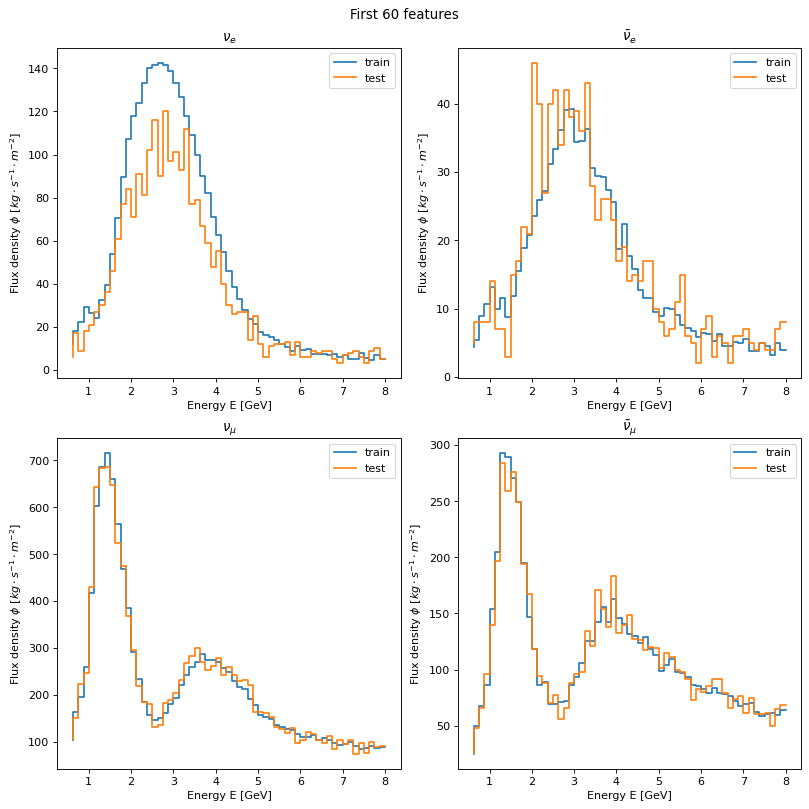

Success to plot


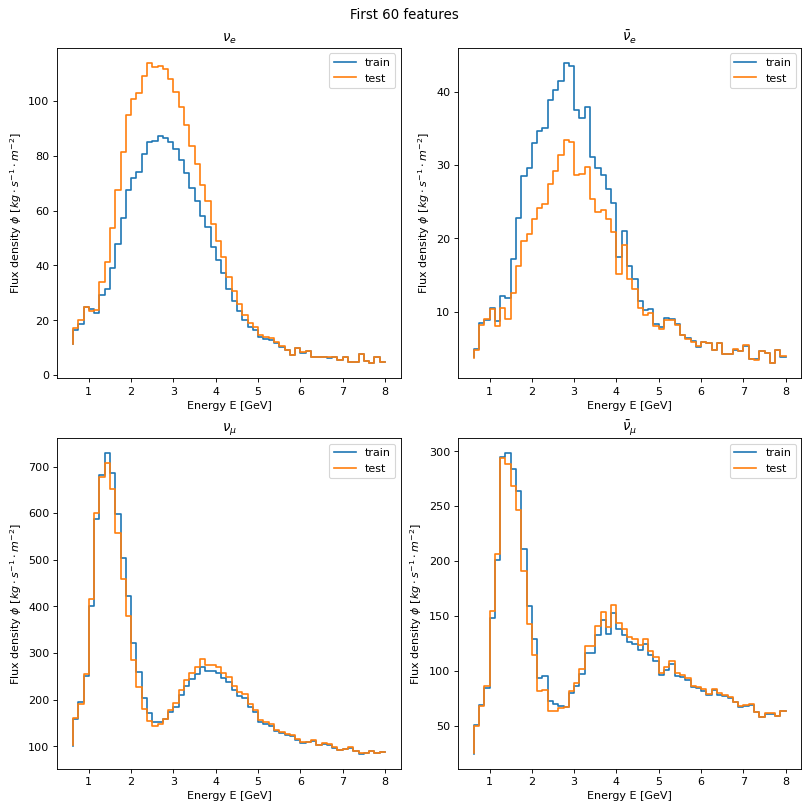

Success to plot


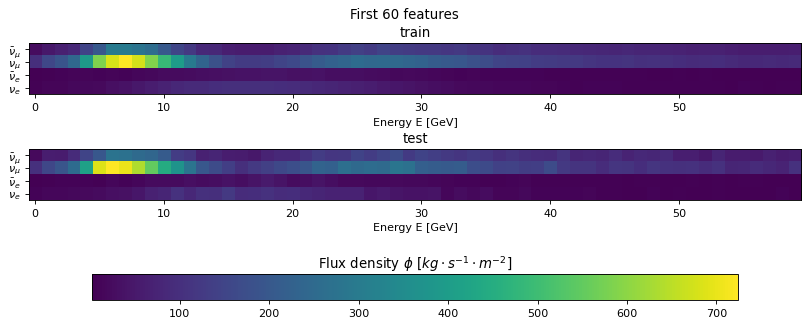

Success to plot


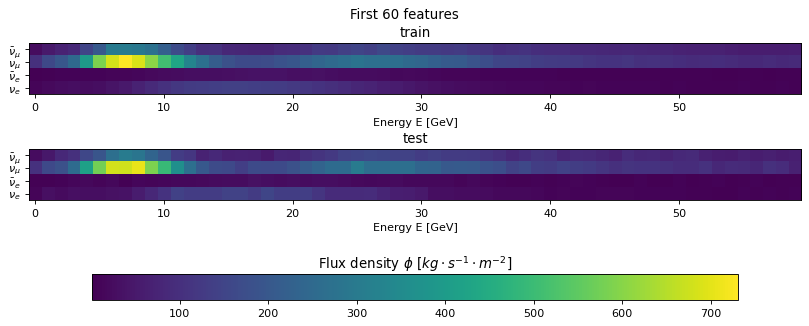

Success to plot


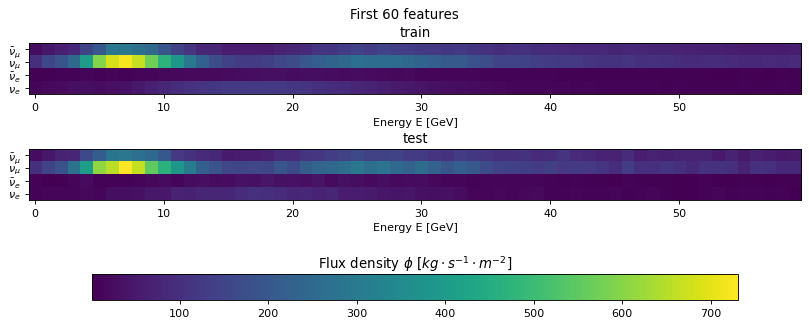

Success to plot


In [176]:
# inspect data structures

# check ``1D images''
train_10 = [ve_train[10], vebar_train[10], vu_train[10], vubar_train[10]]
test_10 = [ve_test[10], vebar_test[10], vu_test[10], vubar_test[10]]
train_average = [
    np.average(ve_train, axis=0),
    np.average(vebar_train, axis=0),
    np.average(vu_train, axis=0),
    np.average(vubar_train, axis=0),
]
test_average = [
    np.average(ve_test, axis=0),
    np.average(vebar_test, axis=0),
    np.average(vu_test, axis=0),
    np.average(vubar_test, axis=0),
]
data_format = [train_10, test_10]
data_sum_format = [train_average, test_average]
four_plot(data_format)
four_plot(data_sum_format)

# check ``2D images''
for i in [9, 99, 999]:
    data_format = [X_train[i, 0:60, :], X_test[i, 0:60, :]]
    four_2d_plot(data_format)


The max of $\Theta_{13}$ [rad] is 51.1;
The min of $\Theta_{13}$ [rad] is 38.9;
The avg of $\Theta_{13}$ [rad] is 45.002699455700025.

The max of $\delta_{cp}$ [rad] is 360.0;
The min of $\delta_{cp}$ [rad] is 8.54954e-05;
The avg of $\delta_{cp}$ [rad] is 180.1832076771041.



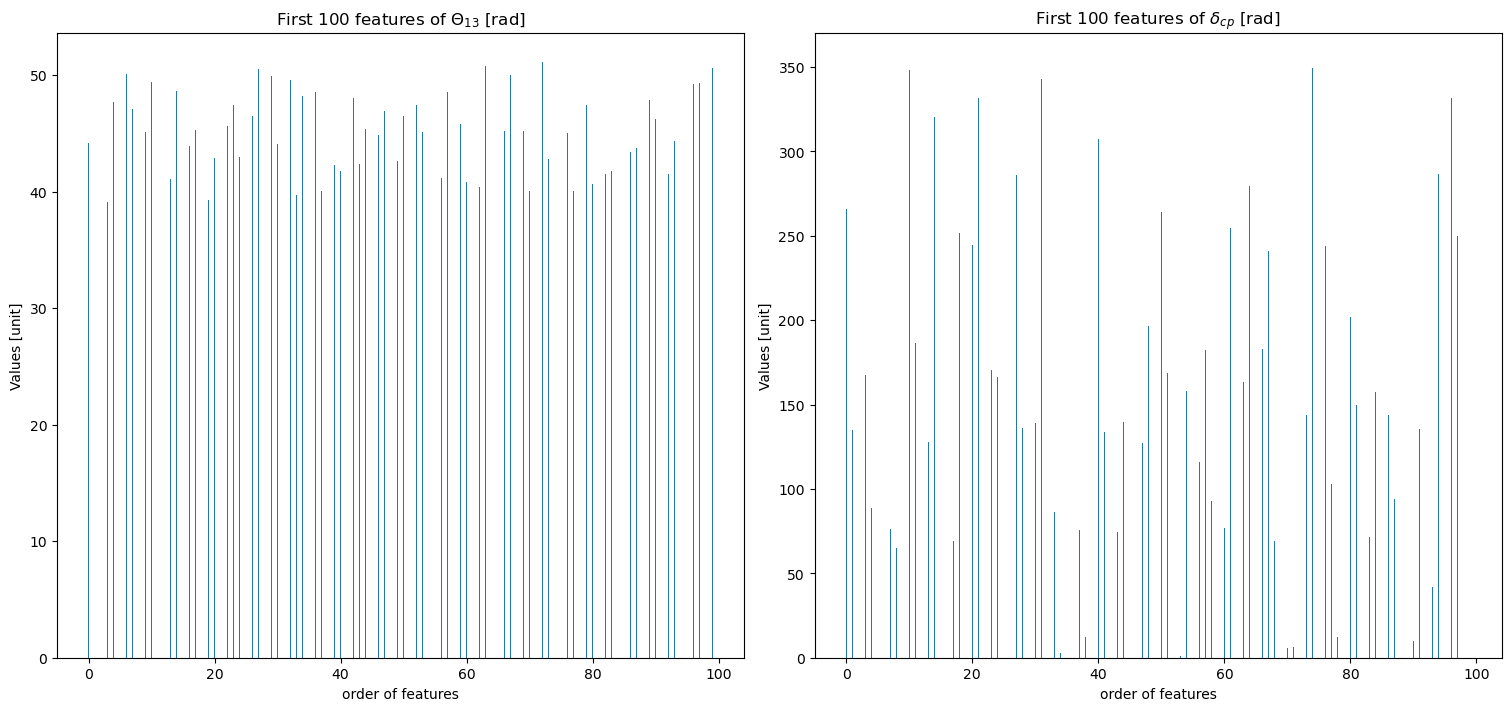

In [177]:
# check theta and delta relations

fig, axes = plt.subplots(1, 2, figsize=(15, 7), dpi=100, constrained_layout=True)
for i, name in enumerate([r"$\Theta_{13}$ [rad]", r"$\delta_{cp}$ [rad]"]):
    print(
        f"""The max of {name} is {np.max(Y_train[:, i])};
The min of {name} is {np.min(Y_train[:, i])};
The avg of {name} is {np.average(Y_train[:, i])}.
"""
    )
    ax = axes[i]
    n = 100
    ax.bar(np.arange(n), Y_train[:n, i], width=0.1)
    ax.set_title(f"First 100 features of {name}")
    ax.set_xlabel("order of features")
    ax.set_ylabel("Values [unit]")
plt.show()


In [180]:
# create validation data
from sklearn.model_selection import train_test_split

# split the training dataset into training and validation, with test_size = 0.2
tf.random.set_seed(2023)
x_train, x_val, y_train, y_val = train_test_split(
    X_train, Y_train[:, 0:2], test_size=0.2, shuffle=True
)
x_test = X_test
print(
    f"""
The shape of x_train     : {x_train.shape}
The shape of y_train     : {y_train.shape}
The shape of x_validation: {x_val.shape}
The shape of y_validation: {y_val.shape}
The shape of x_test      : {x_test.shape}
"""
)


The shape of x_train     : (800000, 65, 4)
The shape of y_train     : (800000, 2)
The shape of x_validation: (200000, 65, 4)
The shape of y_validation: (200000, 2)
The shape of x_test      : (1000, 65, 4)



### model


In [181]:
# Define sample_z function

from tensorflow.keras.backend import random_normal


def sample_z(inputs: list):
    z_mean, z_log_var = inputs
    batch = tf.shape(z_mean)[0]
    dim = tf.shape(z_mean)[1]
    epsilon = random_normal(shape=(batch, dim))

    return z_mean + tf.exp(0.5 * z_log_var) * epsilon


In [182]:
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Layer


class KLDivergenceLayer(Layer):

    """Identity transform layer that adds KL divergence
    to the final model loss.
    """

    def __init__(self, *args, **kwargs):
        self.is_placeholder = True
        super(KLDivergenceLayer, self).__init__(*args, **kwargs)

    def call(self, inputs):
        mu, log_var = inputs
        kl_batch = -0.5 * K.sum(1 + log_var - K.square(mu) - K.exp(log_var), axis=-1)
        self.add_loss(K.mean(kl_batch), inputs=inputs)

        return inputs

In [275]:
# from tensorflow.keras import Model, Input
# from tensorflow.keras.layers import (
#     Reshape,
#     Conv2D,
#     MaxPooling2D,
#     Conv2DTranspose,
#     LeakyReLU,
#     Flatten,
#     Dense,
#     Lambda,
#     Dropout,
# )


# def conv2d(inputs):
#     x = Conv2D(32, kernel_size=3, strides=1, padding="same")(inputs)
#     x = MaxPooling2D(pool_size=(2, 2))(x)
#     x = Flatten()(x)
#     return x


# def deconv2d(inputs, output_shape):
#     x = Conv2DTranspose(10, kernel_size=3, strides=1, padding="same")(inputs)
#     x = LeakyReLU(alpha=0.2)(x)
#     x = Reshape(output_shape)(x)
#     return x


# def fin_DNN(inputs):
#     x = Flatten()(inputs)
#     x = Dense(64, activation="relu")(x)
#     x = Dropout(0.2)(x)
#     x = Dense(16, activation="relu")(x)
#     x = Dropout(0.2)(x)
#     x = Dense(2, activation="relu")(x)
#     return x


# def create_vae_model(input_dim, latent_dim):
#     # Encoder
#     encoder_inputs = Input(shape=input_dim)
#     x = conv2d(encoder_inputs)
#     x = Dense(64, activation="relu")(x)
#     x = Reshape((8, 8, 1))(x)
#     x = conv2d(x)
#     x = Dense(16, activation="relu")(x)
#     z_mu = Dense(latent_dim)(x)
#     z_log_var = Dense(latent_dim)(x)
#     z_mu, z_log_var = KLDivergenceLayer()([z_mu, z_log_var])
#     z = Lambda(sample_z, output_shape=(latent_dim,))([z_mu, z_log_var])
#     encoder = Model(encoder_inputs, [z_mu, z_log_var, z], name="encoder")
#     encoder.summary()

#     # Decoder
#     latent_inputs = Input(shape=(latent_dim,))
#     x = Dense(8, activation="relu")(latent_inputs)
#     x = Dense(13 * 2, activation="relu")(x)
#     x = Dropout(0.2)(x)
#     x = Reshape((13, 2, 1))(x)
#     x = deconv2d(x, output_shape=(65, 4, 1))
#     x = fin_DNN(x)
#     decoder = Model(latent_inputs, x, name="decoder")
#     decoder.summary()

#     # VAE
#     autoencoder_input = Input(shape=input_dim)
#     encoded = encoder(autoencoder_input)
#     decoded = decoder(encoded[2])
#     vae = Model(inputs=autoencoder_input, outputs=decoded)
#     return vae


In [278]:
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import (
    Reshape,
    Conv2D,
    MaxPooling2D,
    Conv2DTranspose,
    LeakyReLU,
    Flatten,
    Dense,
    Lambda,
    Dropout,
)


def conv2d_tf(inputs):
    x = Conv2D(32, kernel_size=3, strides=1, padding="same")(inputs)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Conv2D(32, kernel_size=3, strides=1, padding="same")(inputs)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Flatten()(x)
    return x


def deconv2d_tf(inputs, output_shape):
    x = Conv2DTranspose(10, kernel_size=3, strides=1, padding="same")(inputs)
    x = LeakyReLU(alpha=0.2)(x)
    x = Conv2DTranspose(10, kernel_size=3, strides=1, padding="same")(inputs)
    x = LeakyReLU(alpha=0.2)(x)
    x = Conv2DTranspose(10, kernel_size=3, strides=1, padding="same")(inputs)
    x = LeakyReLU(alpha=0.2)(x)
    x = Reshape(output_shape)(x)
    return x


def fin_DNN_tf(inputs):
    x = Flatten()(inputs)
    x = Dense(64, activation="relu")(x)
    x = Dropout(0.2)(x)
    x = Dense(16, activation="relu")(x)
    x = Dropout(0.2)(x)
    x = Dense(2, activation="relu")(x)
    return x


def create_vae_model_tf(input_dim, latent_dim):
    # Encoder
    encoder_inputs = Input(shape=input_dim)
    x = conv2d_tf(encoder_inputs)
    x = Dense(64, activation="relu")(x)
    x = Reshape((8, 8, 1))(x)
    x = conv2d_tf(x)
    x = Dense(16, activation="relu")(x)
    z_mu = Dense(latent_dim)(x)
    z_log_var = Dense(latent_dim)(x)
    z_mu, z_log_var = KLDivergenceLayer()([z_mu, z_log_var])
    z = Lambda(sample_z, output_shape=(latent_dim,))([z_mu, z_log_var])
    encoder = Model(encoder_inputs, [z_mu, z_log_var, z], name="encoder")
    encoder.summary()

    # Decoder
    latent_inputs = Input(shape=(latent_dim,))
    x = Dense(8, activation="relu")(latent_inputs)
    x = Dense(13 * 2, activation="relu")(x)
    x = Dropout(0.2)(x)
    x = Reshape((13, 2, 1))(x)
    x = deconv2d_tf(x, output_shape=(65, 4, 1))
    x = fin_DNN_tf(x)
    decoder = Model(latent_inputs, x, name="decoder")
    decoder.summary()

    # VAE
    autoencoder_input = Input(shape=input_dim)
    encoded = encoder(autoencoder_input)
    decoded = decoder(encoded[2])
    vae = Model(inputs=autoencoder_input, outputs=decoded)
    return vae


In [279]:
# Declare the model and encoder
# vae = create_vae_model(input_dim=(x_train.shape[1], x_train.shape[2], 1), latent_dim=2)
vae = create_vae_model_tf(
    input_dim=(x_train.shape[1], x_train.shape[2], 1), latent_dim=2
)

# Compile the model
vae.compile(optimizer="adam", loss="mse")

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_191 (InputLayer)         [(None, 65, 4, 1)]   0           []                               
                                                                                                  
 conv2d_118 (Conv2D)            (None, 65, 4, 32)    320         ['input_191[0][0]']              
                                                                                                  
 max_pooling2d_112 (MaxPooling2  (None, 32, 2, 32)   0           ['conv2d_118[0][0]']             
 D)                                                                                               
                                                                                                  
 flatten_140 (Flatten)          (None, 2048)         0           ['max_pooling2d_112[0][0]']

In [ ]:
# from tensorflow.keras.callbacks import EarlyStopping

# early_stopping = EarlyStopping(
#     monitor="val_loss",
#     min_delta=0.005,
#     patience=20,
#     mode="auto",
#     baseline=None,
#     restore_best_weights=False,
# )
# vae.fit(
#     x=x_train,
#     y=y_train[:,0],
#     validation_data=(x_val, y_val[:,0]),
#     epochs=20,
#     batch_size=512,
#     callbacks=[early_stopping],
#     shuffle=True,
#     verbose=1,
# )


In [280]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor="val_loss",
    min_delta=0.005,
    patience=20,
    mode="auto",
    baseline=None,
    restore_best_weights=False,
)
vae.fit(
    x=x_train,
    y=y_train[:, 0],
    validation_data=(x_val, y_val[:, 0]),
    epochs=50,
    batch_size=1024,
    callbacks=[early_stopping],
    shuffle=True,
    verbose=1,
)

Epoch 1/20


2023-05-19 01:12:56.631181: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1563/1563 [==============================] - ETA: 0s - loss: 123.4450

2023-05-19 01:14:10.018136: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1563/1563 [==============================] - 81s 50ms/step - loss: 123.4450 - val_loss: 30.2091
Epoch 2/20
1563/1563 [==============================] - 75s 48ms/step - loss: 26.8208 - val_loss: 65.5782
Epoch 3/20
1563/1563 [==============================] - 80s 51ms/step - loss: 7.4916 - val_loss: 66.4423
Epoch 4/20
1563/1563 [==============================] - 85s 54ms/step - loss: 5.2678 - val_loss: 64.0547
Epoch 5/20
1563/1563 [==============================] - 73s 46ms/step - loss: 4.2713 - val_loss: 60.6198
Epoch 6/20
1435/1563 [==========================>...] - ETA: 6s - loss: 3.4983

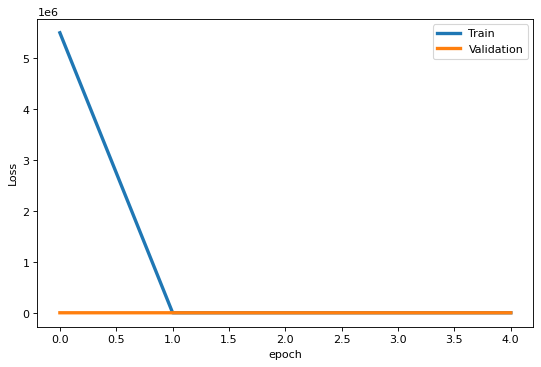

In [206]:
fig = plt.figure(figsize=(8, 5), dpi=100)
history = vae.history.history
plt.plot(history["loss"], lw=2.5, label="Train", alpha=0.8)
plt.plot(history["val_loss"], lw=2.5, label="Validation", alpha=0.8)
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.legend(loc="best")
plt.show()

### dump the predicted data


In [ ]:
# # dump the predicted data
# """
# 0 for qcd; 1 for wprime
# """

# pred_label = [0 if i < cut else 1 for i in new_loss_data]
# np.savetxt("submission.csv", [('id', 'prediction')] + [(i, j) for i, j in enumerate(pred_label)], delimiter=",", fmt='%s')
